<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a  href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель исследования:**  
Построить модель для прогнозирования количества заказов на следующий час со значением метрики RMSE ниже 48.

**Ход исследования:**  
* Импорт библиотек
* Загрузка данных
* Анализ данных
* Создание признаков для обучения моделей
* Разбивка данных на выборки
* Обучение моделей, нахождение RMSE
* Проверка моделей на тестовой выборке

## Подготовка

In [1]:
#Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [2]:
#Сохраним данные в переменную data
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
#Посмотрим информацию о данных
data.info()

<class 'pandas.core.frame.DataFrame'>

DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00

Data columns (total 1 columns):

 #   Column      Non-Null Count  Dtype

---  ------      --------------  -----

 0   num_orders  26496 non-null  int64

dtypes: int64(1)

memory usage: 414.0 KB


In [4]:
#Выведем первые пять строк таблицы на экран
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
#Отсортируем индексы по увеличению дат
data.sort_index(inplace=True)

In [6]:
#Проверим, в хронологоческом ли порядке расположены даты и время
data.index.is_monotonic

True

In [7]:
#Выполним ресемплирование данных по одному часу
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


**Вывод:**  
* Данные изучены
* Проведено ресемплирование данных

## Анализ

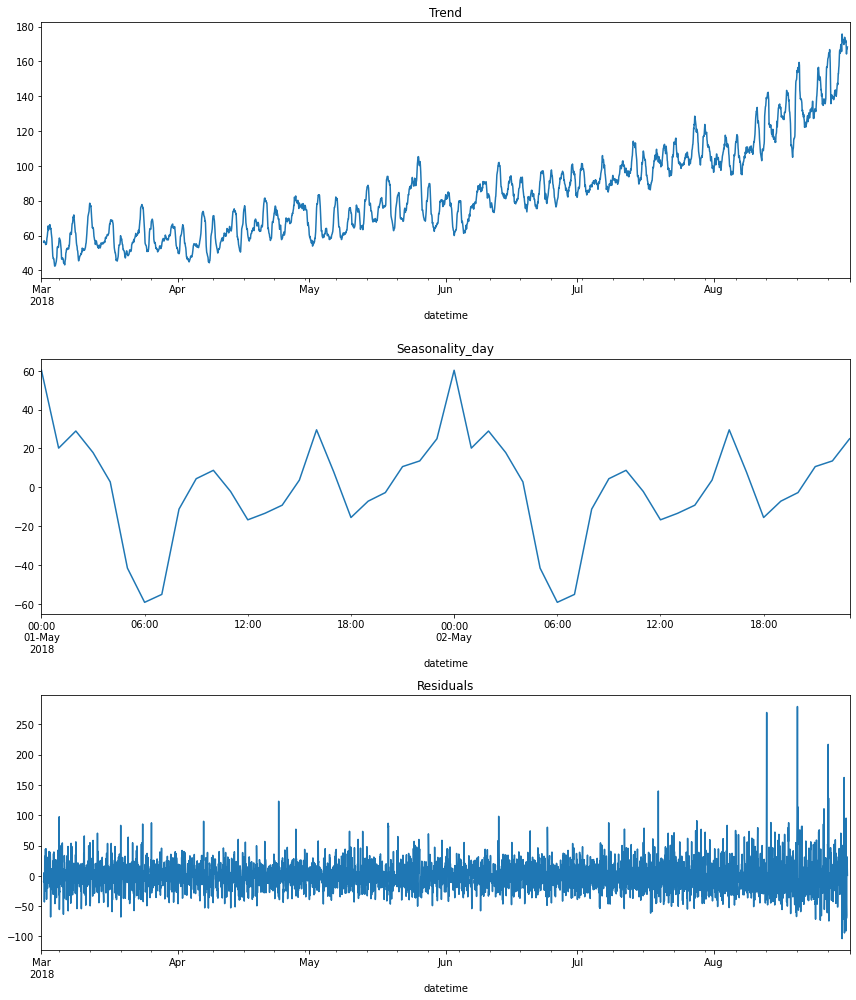

In [8]:
#Изучим тренды и сезонность
decomposed = seasonal_decompose(data)
plt.figure(figsize=(12, 14))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-05-01':'2018-05-02'].plot(ax=plt.gca())
plt.title('Seasonality_day')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Text(0.5, 1.0, 'Seasonality_week')

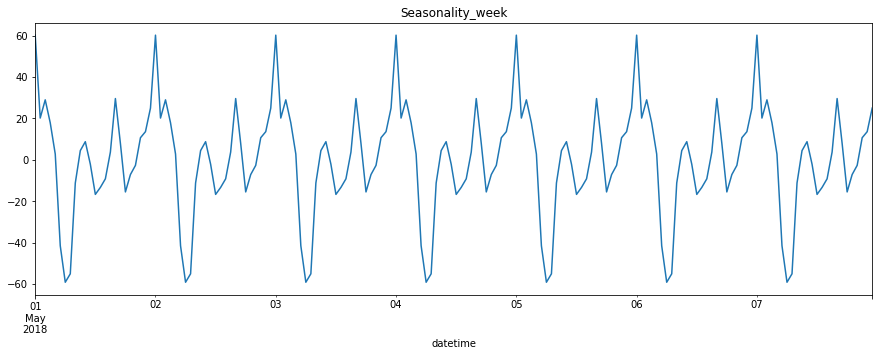

In [9]:
#Построим график сезонности за неделю
plt.figure(figsize=(15, 5))
decomposed.seasonal['2018-05-01':'2018-05-07'].plot(ax=plt.gca())
plt.title('Seasonality_week')

**Вывод:**  
* По графику **тренд** видно, что количество заказов увеличивается с каждым месяцем
* По графику **сезонность за день** - самое меньшее количество заказов происходит в 6 утра, самое большее - в 00 часов
* Шумы необъяснимы
* По графику **сезонность за неделю** - количество заказов не меняется в зависимости от дня недели

## Обучение

In [10]:
#Создадим признаки для обучения модели
data_1 = data.copy()

def make_features(data_1, max_lag, rolling_mean_size):
    data_1['month'] = data_1.index.month
    data_1['day'] = data_1.index.day
    data_1['dayofweek'] = data_1.index.dayofweek
    data_1['hour'] = data_1.index.hour
    
    for lag in range(1, max_lag + 1):
        data_1['lag_{}'.format(lag)] = data_1['num_orders'].shift(lag)
    
    data_1['rolling_mean'] = data_1['num_orders'].shift().rolling(rolling_mean_size).mean()

    
make_features(data_1, 24, 10)
data_1.head()

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
#Удалим пропуски
data_1.dropna(inplace=True)

In [12]:
#Разобъём данные на выборки
train, valid = train_test_split(data_1, shuffle=False, test_size=0.2, random_state=12345)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5, random_state=12345)
train = train.dropna()

In [13]:
#Проверим деление выборок
print(train.shape)
print(valid.shape)
print(test.shape)

(3513, 30)

(439, 30)

(440, 30)


In [14]:
#Разобъём выборки на признаки и целевые признаки
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

**Обучим модель линейной регрессии**

In [15]:
model_lr = LinearRegression()
 
model_lr.fit(features_train, target_train)
pred_valid_lr = model_lr.predict(features_valid)
rmse_lr = mean_squared_error(target_valid, pred_valid_lr)**0.5
print(rmse_lr)

34.2280883141464


RMSE в пределах заданного значения

**Обучим модель случайного леса**

In [16]:
#Надём лучшую глубину деревьев
for depth in range(12, 30, 3):
    model_forest = RandomForestRegressor(random_state=12345, max_depth = depth)
    model_forest.fit(features_train, target_train)
    predictions_valid_forest = model_forest.predict(features_valid)
    rmse_forest = mean_squared_error(target_valid, predictions_valid_forest)**0.5
    print('Глубина:', depth)
    print('RMSE для решающего дерева:', rmse_forest)
    print('')
print()

Глубина: 12

RMSE для решающего дерева: 31.860281265946814



Глубина: 15

RMSE для решающего дерева: 31.830525275822243



Глубина: 18

RMSE для решающего дерева: 31.700546107922463



Глубина: 21

RMSE для решающего дерева: 31.8536523432193



Глубина: 24

RMSE для решающего дерева: 31.708298804250234



Глубина: 27

RMSE для решающего дерева: 31.68736943139932






In [17]:
#Подберём гиперпараметры и обучим модель
for est in [100, 300, 1000]:
    model_forest = RandomForestRegressor(random_state=12345, 
                                   n_estimators=est, 
                                   max_depth=18)
    model_forest.fit(features_train, target_train)
    predictions_forest = model_forest.predict(features_valid)
    rmse_forest = mean_squared_error(target_valid, predictions_forest)**0.5
    print('Количество деревьев:', est)
    print('RMSE случайного леса:', rmse_forest)
    print('')
print()

Количество деревьев: 100

RMSE случайного леса: 31.700546107922463



Количество деревьев: 300

RMSE случайного леса: 31.570733441420128



Количество деревьев: 1000

RMSE случайного леса: 31.61466073513683






RMSE у случайного леса лучше, чем у линейной регрессии

**Обучим модель LightGBM**

In [18]:
#Найдём лучшие параметры для модели
splits = TimeSeriesSplit(n_splits=3)
model_lg = lgb.LGBMRegressor(random_state=12345)
params_gr = {'n_estimators': [60, 100, 300], 'num_leaves': [50, 200, 500], 'max_depth': [10, 20]}

grid = GridSearchCV(model_lg, params_gr, scoring='neg_root_mean_squared_error', cv=splits)

grid.fit(features_train, target_train)

print(grid.best_params_)
print(grid.best_score_*-1)

{'max_depth': 10, 'n_estimators': 60, 'num_leaves': 200}

24.925769612885997


In [19]:
#Обучим модель с подобранными параметрами
model_lg = lgb.LGBMRegressor(random_state=12345, n_estimators=60, num_leaves=200, max_depth=10)
model_lg.fit(features_train, target_train)
predictions_valid_lg = model_lg.predict(features_valid)
rmse_lg = mean_squared_error(target_valid, predictions_valid_lg)**0.5
print(rmse_lg)

31.214641436591258


RMSE у LightGBM лучше, чем у других моделей проведём тестирование на ней

## Тестирование

In [23]:
#Объединим тренировочную и валидационну выборки и протестируем модель
features_train_valid = pd.concat([features_train, features_valid]) 
target_train_valid = pd.concat([target_train, target_valid]) 

model_lg = lgb.LGBMRegressor(random_state=12345, n_estimators=60, num_leaves=200, max_depth=10)
model_lg.fit(features_train_valid, target_train_valid) 
predictions_test_lg = model_lg.predict(features_test)
rmse_lg = mean_squared_error(target_test, predictions_test_lg)**0.5
print(rmse_lg)

41.182034084457655


RMSE на тестовой выборке в пределах допустимого значения

**Вывод:**  
* Данные были загружены и проанализированы
* Рассмотрены тренды и сезонность на графиках
* Выбраны и обучены три модели с различными гиперпараметрами
* Выполнены предсказания на валидационной выборке
* Проведено тестирование модели на объединённых тренировочной и валидационной выборках (полученное значение в пределах допустимого)

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.linear_model import LogisticRegression

train = pd.read_csv('/datasets/tweets_lemm_train.csv')
corpus_train = train['lemm_text'].values.astype('U')
 
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('russian'))
 
count_tf_idf = TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)
t_train = train['positive']

model = LogisticRegression()
model.fit(tf_idf_train, t_train)

test = pd.read_csv('/datasets/tweets_lemm_test.csv')
corpus_test = test['lemm_text'].values.astype('U')
tf_idf_test = count_tf_idf.transform(corpus_test)

print(tf_idf_test.shape)

predictions = model.predict(tf_idf_test)
predict_df = pd.DataFrame(predictions, columns=['positive'])

print(predict_df.head())

predict_df.to_csv('predicts.csv')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...

[nltk_data]   Package stopwords is already up-to-date!


(3000, 9737)

   positive

0         1

1         0

2         0

3         0

4         1
